In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("1976-2020-senate.csv")

In [3]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']
vote_df = grouped[['DEMOCRAT_pct', 'REPUBLICAN_pct']]

In [4]:
years = grouped.index.values
t = years - years[0]
vote_A = grouped['DEMOCRAT_pct'].values
vote_B = grouped['REPUBLICAN_pct'].values

In [5]:
D = vote_A # dem
R = vote_B # rep
t = (years - years[0]) / (years[-1] - years[0])

In [6]:
t = torch.tensor(t, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
D = torch.tensor(D / 100.0, dtype=torch.float32).unsqueeze(1)
R = torch.tensor(R / 100.0, dtype=torch.float32).unsqueeze(1)

In [7]:
Y = torch.cat([D, R], dim=1)

In [8]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, t):
        return self.net(t)

In [9]:
def pinn_loss(model, t, y_obs):
    y_pred = model(t)
    D_pred, R_pred = y_pred[:, 0:1], y_pred[:, 1:2]

    # Compute derivatives w.r.t time
    dydt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred),
                               retain_graph=True, create_graph=True)[0]
    dDdt = dydt[:, 0:1]
    dRdt = dydt[:, 1:2]

    # Physics-inspired constraints (example: prey-predator like dynamics)
    f1 = dDdt - (D_pred * (1 - D_pred) - D_pred * R_pred)
    f2 = dRdt - (-R_pred + D_pred * R_pred)

    # Loss: data fitting + physics constraint
    data_loss = torch.mean((y_pred - y_obs)**2)
    physics_loss = torch.mean(f1**2) + torch.mean(f2**2)
    return data_loss + physics_loss, data_loss.detach(), physics_loss.detach()


In [10]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
for epoch in range(5000):
    optimizer.zero_grad()
    loss, data_l, phys_l = pinn_loss(model, t, Y)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss={loss.item():.6f}, Data={data_l:.6f}, Physics={phys_l:.6f}")


Epoch 0: Total Loss=nan, Data=0.182418, Physics=nan
Epoch 500: Total Loss=nan, Data=0.001081, Physics=nan
Epoch 1000: Total Loss=nan, Data=0.001043, Physics=nan
Epoch 1500: Total Loss=nan, Data=0.001038, Physics=nan
Epoch 2000: Total Loss=nan, Data=0.001060, Physics=nan
Epoch 2500: Total Loss=nan, Data=0.001035, Physics=nan
Epoch 3000: Total Loss=nan, Data=0.001037, Physics=nan
Epoch 3500: Total Loss=nan, Data=0.001032, Physics=nan
Epoch 4000: Total Loss=nan, Data=0.001032, Physics=nan
Epoch 4500: Total Loss=nan, Data=0.001031, Physics=nan


In [12]:
with torch.no_grad():
    pred = model(t)
    D_pred = pred[:, 0].numpy() * 100
    R_pred = pred[:, 1].numpy() * 100

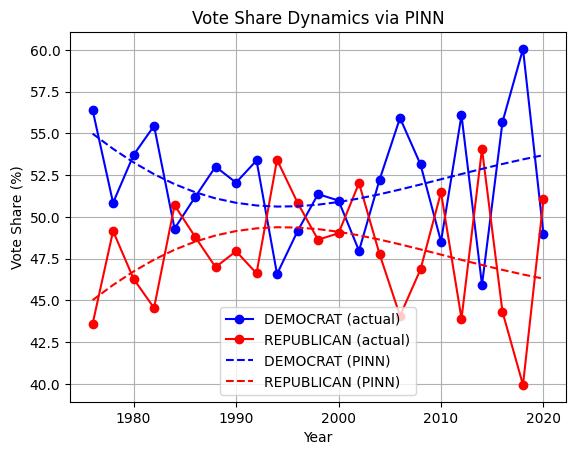

In [13]:
plt.plot(years, D.numpy().squeeze() * 100, 'bo-', label='DEMOCRAT (actual)')
plt.plot(years, R.numpy().squeeze() * 100, 'ro-', label='REPUBLICAN (actual)')
plt.plot(years, D_pred, 'b--', label='DEMOCRAT (PINN)')
plt.plot(years, R_pred, 'r--', label='REPUBLICAN (PINN)')
plt.xlabel("Year")
plt.ylabel("Vote Share (%)")
plt.legend()
plt.title("Vote Share Dynamics via PINN")
plt.grid(True)
plt.show()